# This notebook analyzes skew experiments on Adult data by visualizing results.

Organize imports, set constants, and load result files.

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from ast import literal_eval

CONSTANT = 3
PATH = f'log{CONSTANT}/'

df_t = pd.read_csv(f'{PATH}results_teachers.csv')
df_v = pd.read_csv(f'{PATH}results_voting.csv')
df_s = pd.read_csv(f'{PATH}results_student.csv')

df_tb = pd.read_csv(f'{PATH}baseline/results_teachers.csv')
df_vb = pd.read_csv(f'{PATH}baseline/results_voting.csv')
df_sb = pd.read_csv(f'{PATH}baseline/results_student.csv')

Define constants and colors.

In [2]:
colors = {
    'non-personalized': 'dimgray',
    'upsampling': 'deepskyblue',
    'vanishing': 'gold',
    'weighting': 'fuchsia',
}

colors2 = {
    'non-personalized': 'dimgray',
    'upsampling (high)': 'cornflowerblue',
    'upsampling (low)': 'deepskyblue',
    'vanishing    (high)': 'greenyellow',
    'vanishing    (low)': 'gold',
    'weighting    (high)': 'tomato',
    'weighting    (low)': 'fuchsia',
}

In [3]:
df = df_v

kinds = {
    'GNMax': 'non-personalized',
    'uGNMax': 'upsampling',
    'vGNMax': 'vanishing',
    'wGNMax': 'weighting',
}

res = {
    'labels': [],
    'collector': [],
    'group': [],
    'budget': [],
    'distribution': [],
    'cost': [],
}
for row in range(len(df)):
    data = df.iloc[row]
    aggregator = data['aggregator']
    collector = data['collector']
    budgets = data['budgets']
    dist = data['distribution']
    n_teachers = data['n_teachers']
    seed = data['seed']
    seed2 = data['seed2']
    delta = data['delta']
    sigma = data['sigma']
    sigma1 = data['sigma1']
    t = data['t']
    kind = kinds[collector]
    preds = pd.read_csv(f'{PATH}/data/voting_data/{n_teachers}_teachers_{budgets}_{dist}/seed_{seed}_{seed2}/' \
                        f'{aggregator}_{collector}_{delta}_{sigma}_{sigma1}_{t}_data.csv', header=0)['pred']
    costs0 = np.array(literal_eval(data['costs_curve']))[preds != -1, 0]
    costs1 = np.array(literal_eval(data['costs_curve']))[preds != -1, -1]
    
    kl = kind + ' (low)' if kind == 'upsampling' else kind + '    (low)'
    kh = kind + ' (high)' if kind == 'upsampling' else kind + '    (high)'
    for i in range(2000):
        res['labels'].append(i + 1)
        res['collector'].append(collector)
        res['group'].append(kl)
        res['budget'].append(literal_eval(budgets)[-1])
        res['distribution'].append(dist)
        res['cost'].append(costs0[i])
        
        res['labels'].append(i + 1)
        res['collector'].append(collector)
        res['group'].append(kh)
        res['budget'].append(literal_eval(budgets)[-1])
        res['distribution'].append(dist)
        res['cost'].append(costs1[i])


df = df_vb.sample(frac=1)
for row in range(len(df)):
    data = df.iloc[row]
    collector = data['collector']
    budgets = data['budgets']
    dist = data['distribution']
    n_teachers = data['n_teachers']
    seed = data['seed']
    seed2 = data['seed2']
    aggregator = data['aggregator']
    delta = data['delta']
    sigma = int(data['sigma'])
    sigma1 = int(data['sigma1'])
    t = int(data['t'])
    preds = pd.read_csv(f'{PATH}baseline/data/voting_data/{n_teachers}_teachers_{budgets}_{dist}/seed_{seed}_{seed2}/' \
                        f'{aggregator}_{collector}_{delta}_{sigma}_{sigma1}_{t}_data.csv', header=0)['pred']
    costs0 = np.array(literal_eval(data['costs_curve']))[preds != -1, 0]

    for i in range(2000):
        res['labels'].append(i + 1)
        res['collector'].append(collector)
        res['group'].append('non-personalized')
        res['budget'].append(math.log(CONSTANT))
        res['distribution'].append(dist)
        res['cost'].append(costs0[i])
        
df_new = pd.DataFrame(res)
df_new.to_csv(path_or_buf=f'voting_processed_c{CONSTANT}.csv', index=False, mode='w', header=True)

In [3]:
df_new = pd.read_csv(f'voting_processed_c{CONSTANT}.csv', header=0)

...

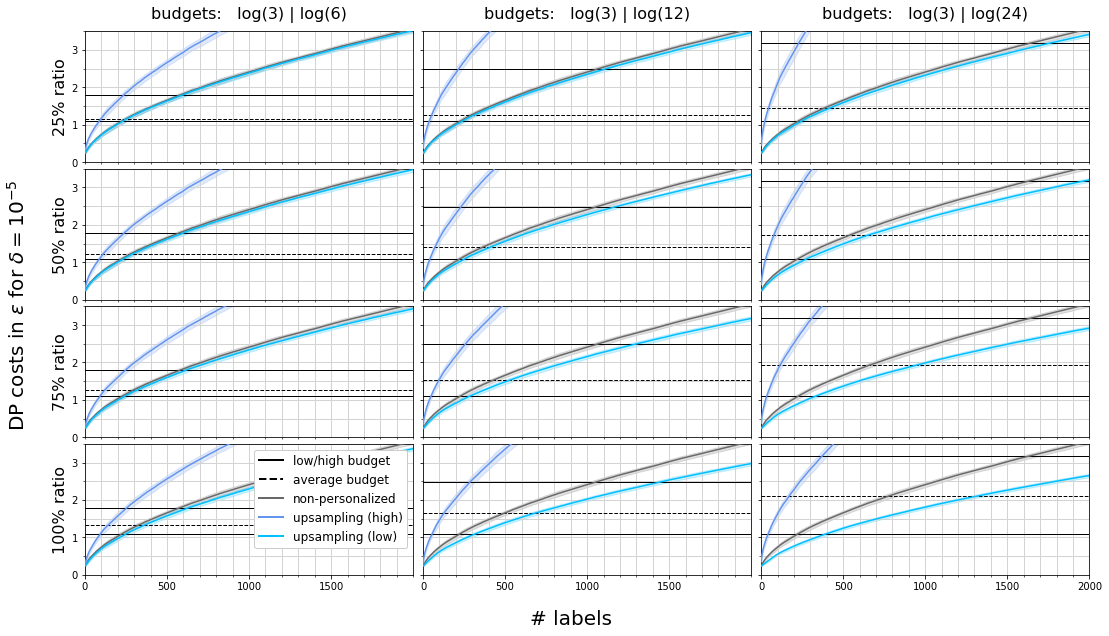

In [4]:
plt.rcParams['axes.titley'] = 1.05
fig, axes = plt.subplots(nrows=4, ncols=3, sharex=False, sharey=True, figsize=(18, 10))
plt.subplots_adjust(wspace=0.03, hspace=0.05)

for i, d in enumerate(sorted(df_v['distribution'].unique())[::-1]):
    for j, b in enumerate([round(literal_eval(b)[1], 2) for b in df_v['budgets'].unique()]):
        ax = axes[i, j]
        data = df_new[(df_new['budget'] == b) & (df_new['distribution'] == d) | (df_new['collector'] == 'GNMax')]
        sns.lineplot(data=data, x='labels', y='cost', hue='group', ci='sd', palette=colors2,
                     hue_order=colors2.keys(), alpha=1, ax=ax, legend=False, zorder=8)

labels = [0, 1]
avg_budgets = [[df_v.loc[(df_v['distribution'] == str({0: (1, 0), 1: (w1, w2)}))
                         & (df_v['budgets_linear'] == f'[{e1}, {e2}]')]['avg_budget'].iloc[0]
                for e1, e2 in [(CONSTANT * 1.0, CONSTANT * 2.0),
                               (CONSTANT * 1.0, CONSTANT * 4.0),
                               (CONSTANT * 1.0, CONSTANT * 8.0)]]
               for w1, w2 in [(0.75, 0.25), (0.5, 0.5), (0.25, 0.75), (0, 1)]]
kind = 'upsampling'
budgets = [round(literal_eval(b)[1], 2) for b in df_v['budgets'].unique()]
for i in range(4):
    for j in range(3):
        ax = axes[i, j]
        sns.lineplot(x=[0, 2000], y=[math.log(CONSTANT)] * 2, ax=ax, zorder=2, alpha=1, color='k', linestyle='-', lw=1)
        sns.lineplot(x=[0, 2000], y=[budgets[j]] * 2, ax=ax, zorder=2, alpha=1, color='k', linestyle='-', lw=1)
        sns.lineplot(x=[0, 2000], y=[avg_budgets[i][j]] * 2, ax=ax, zorder=2, alpha=1, color='k', linestyle='--', lw=1)
        ax.xaxis.set_minor_locator(plt.MultipleLocator(100))
        ax.yaxis.set_major_locator(plt.MultipleLocator(1))
        ax.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
        ax.set_xlim(0, 2000)
        ax.set_ylim(0, 3.5)
        ax.grid(which='major', axis='x', color='lightgray', linewidth=1, zorder=1)
        ax.grid(which='minor', axis='x', color='lightgray', linewidth=1, linestyle='-', zorder=1)
        ax.grid(which='major', axis='y', color='lightgray', linewidth=1, zorder=1)
        ax.grid(which='minor', axis='y', color='lightgray', linewidth=1, linestyle='-', zorder=1)
        ax.set_ylabel(f'{25 if i == 0 else 50 if i == 1 else 75 if i == 2 else 100}% ratio',
                      fontsize=16)
        ax.set_xlabel('')


legend_elements = [Line2D([0], [0], linestyle='-', color='k', label='low/high budget', lw=2)] + \
[Line2D([0], [0], linestyle='--', color='k', label='average budget', lw=2)] + \
[Line2D([0], [0], color=colors2[kind], lw=2, label=kind) for kind in [
    'non-personalized', 'upsampling (high)', 'upsampling (low)']]
axes[3, 0].legend(handles=legend_elements, loc='upper right', framealpha=1, fontsize=12).set_zorder(102)
for i in [0, 1, 2]:
    for j in [0, 1, 2]:
        ax = axes[i, j]
        ax.set_xticks([500, 1000, 1500])
        ax.tick_params(axis='x', colors='white')
axes[3, 0].set_xticks([0, 500, 1000, 1500])
axes[3, 1].set_xticks([0, 500, 1000, 1500])
axes[3, 2].set_xticks([0, 500, 1000, 1500, 2000])
axes[0, 0].set_title(f'budgets:   log({CONSTANT}) | log({2 * CONSTANT})', fontsize=16)
axes[0, 1].set_title(f'budgets:   log({CONSTANT}) | log({4 * CONSTANT})', fontsize=16)
axes[0, 2].set_title(f'budgets:   log({CONSTANT}) | log({8 * CONSTANT})', fontsize=16)
fig.supylabel(r'DP costs in $\varepsilon$ for $\delta = 10^{-5}$', fontsize=20, x=0.065, y=0.5)
fig.supxlabel('# labels', fontsize=20, x=0.5, y=0.05)
plt.savefig(fname=f'cost_history_ci_c{CONSTANT}_skew.pdf', format='pdf')
plt.show()